### Part 1
Some data wrangling

Some outlier removal based on domain knowledge

Use Column Transformer and Pipeline to streamline process

Use Randomized Search to find optimal set of parameters

Automate the procedure for multiple classifiers

Plot Precision-Recall Curve

Plot Learning Curve (for bias-variance tradeoff / check for overfitting-underfitting)


### Part 2
Rectify existing model based on inferences from the learning curve and make a better one

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import ConfusionMatrixDisplay

from lightgbm import LGBMClassifier

In [40]:
df = pd.read_csv('credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [41]:
dups = df.duplicated()

In [42]:
df[dups]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4
15989,23,90000,MORTGAGE,7.0,EDUCATION,B,8000,10.36,0,0.09,N,3
15995,24,48000,MORTGAGE,4.0,MEDICAL,A,4000,5.42,0,0.08,N,4
16025,24,10000,RENT,8.0,PERSONAL,A,3000,7.90,1,0.30,N,3
16028,23,100000,MORTGAGE,7.0,EDUCATION,A,15000,7.88,0,0.15,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32010,42,39996,MORTGAGE,2.0,HOMEIMPROVEMENT,A,2500,5.42,0,0.06,N,12
32047,36,250000,RENT,2.0,DEBTCONSOLIDATION,A,20000,7.88,0,0.08,N,17
32172,49,120000,MORTGAGE,12.0,MEDICAL,B,12000,10.99,0,0.10,N,12
32259,39,40000,OWN,4.0,VENTURE,B,1000,10.37,0,0.03,N,16


In [43]:
df.query("person_age==23 & person_income==42000 &\
person_home_ownership=='RENT' & loan_int_rate==9.99")

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
6464,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4


In [44]:
df.shape

(32581, 12)

In [45]:
df.drop_duplicates(inplace=True)

In [46]:
df.shape

(32416, 12)

In [47]:
# X and y will be thought of as the entire training data
# X_test and y_test will be thought of as the out of sample data for model evaluation

X, X_test, y, y_test = train_test_split(df.drop('loan_status', axis=1), df['loan_status'],
                                        random_state=0,  test_size=0.2, stratify=df['loan_status'],
                                        shuffle=True)

In [48]:
df['loan_status'].value_counts(normalize=True)

,proportion
loan_status,
0,0.781312
1,0.218688


In [49]:
y.value_counts(normalize=True)

,proportion
loan_status,
0,0.781313
1,0.218687


In [50]:
y_test.value_counts(normalize=True)

,proportion
loan_status,
0,0.781308
1,0.218692


In [51]:
np.round(X.isna().sum()* 100 / X.shape[0], 3)

,0
person_age,0.000
person_income,0.000
person_home_ownership,0.000
person_emp_length,2.800
loan_intent,0.000
loan_grade,0.000
loan_amnt,0.000
loan_int_rate,9.614
loan_percent_income,0.000
cb_person_default_on_file,0.000


In [52]:
X.shape

(25932, 11)

In [53]:
X.dropna().shape

(22763, 11)

In [54]:
(25932-22763)/25932

0.12220422643837729

In [55]:
X[['person_income', 'loan_amnt', 'loan_percent_income']].head()

,person_income,loan_amnt,loan_percent_income
21415,48000,10000,0.21
12916,85000,7500,0.09
2938,125000,3000,0.02
19114,62000,2300,0.04
6057,48000,4200,0.09


In [56]:
X.drop('loan_percent_income', axis=1, inplace=True)
X_test.drop('loan_percent_income', axis=1, inplace=True)

In [57]:
for col in X:
    print(col, '--->', X[col].nunique())
    if X[col].nunique()<20:
        print(X[col].value_counts(normalize=True)*100)
    print()

person_age ---> 58

person_income ---> 3680

person_home_ownership ---> 4
person_home_ownership
RENT        50.320068
MORTGAGE    41.439149
OWN          7.916859
OTHER        0.323924
Name: proportion, dtype: float64

person_emp_length ---> 36

loan_intent ---> 6
loan_intent
EDUCATION            19.809502
MEDICAL              18.787598
VENTURE              17.542033
PERSONAL             16.878760
DEBTCONSOLIDATION    15.968687
HOMEIMPROVEMENT      11.013420
Name: proportion, dtype: float64

loan_grade ---> 7
loan_grade
A    32.932284
B    32.126330
C    19.902052
D    11.121394
E     3.004010
F     0.732685
G     0.181243
Name: proportion, dtype: float64

loan_amnt ---> 710

loan_int_rate ---> 346

cb_person_default_on_file ---> 2
cb_person_default_on_file
N    82.392411
Y    17.607589
Name: proportion, dtype: float64

cb_person_cred_hist_length ---> 29



In [58]:
X.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,cb_person_cred_hist_length
count,25932.000000,2.593200e+04,25206.000000,25932.000000,23439.000000,25932.000000
mean,27.721155,6.589884e+04,4.811315,9611.395187,11.013784,5.793460
std,6.382311,6.333831e+04,4.172822,6339.054572,3.240104,4.052297
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,2.000000
25%,23.000000,3.849500e+04,2.000000,5000.000000,7.900000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,4.000000
75%,30.000000,7.900000e+04,7.000000,12250.000000,13.480000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,30.000000


In [59]:
num_cols = [col for col in X if X[col].dtypes != 'O']
num_cols

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'cb_person_cred_hist_length']

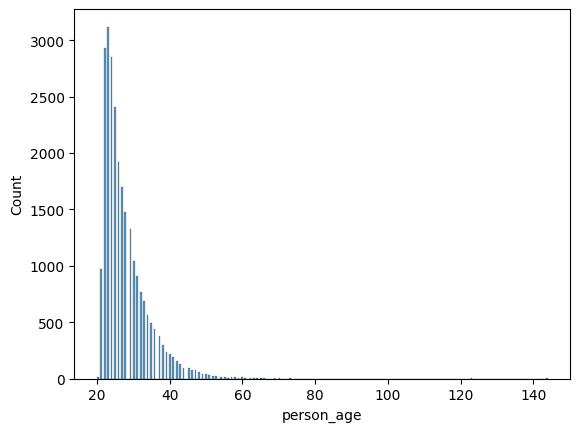

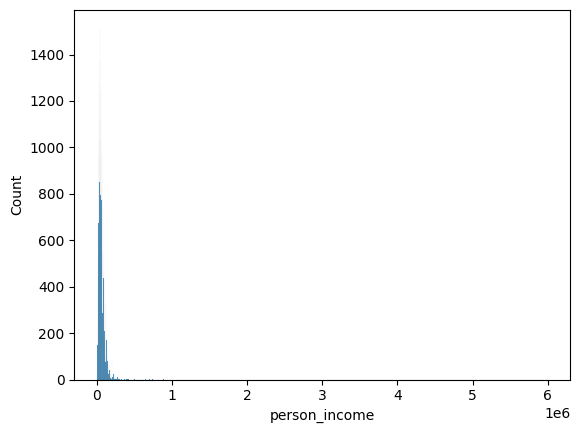

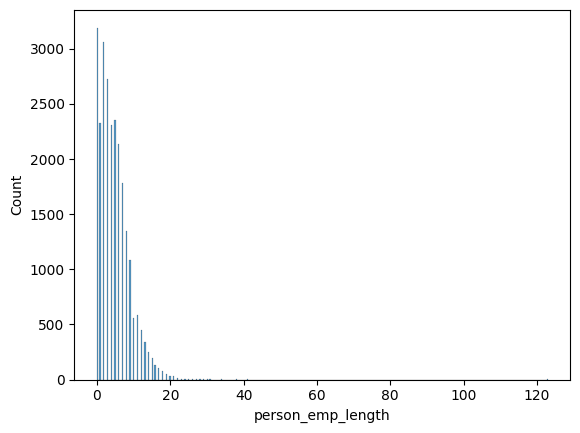

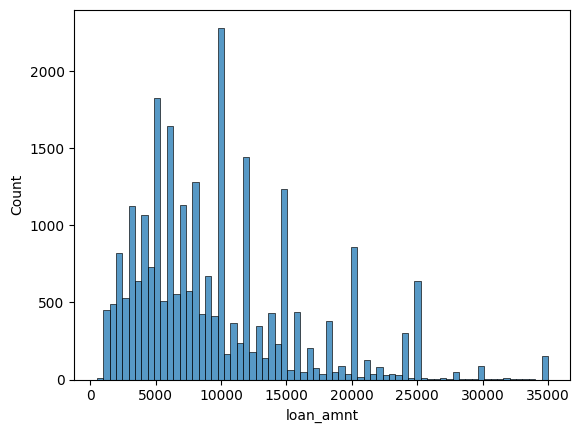

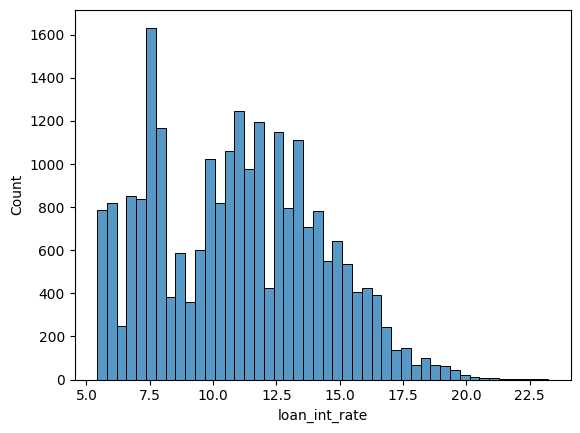

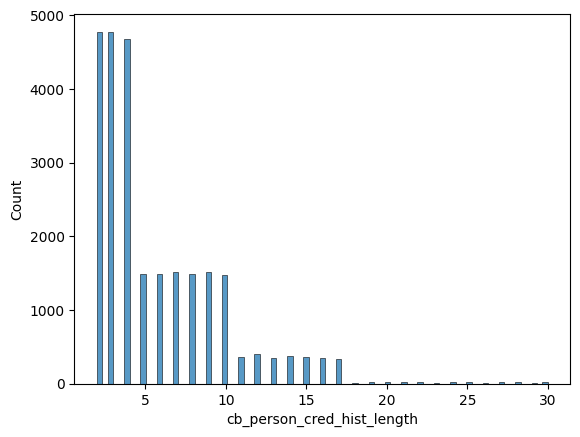

In [60]:
for col in num_cols:
    sns.histplot(X[col])
    plt.show()

In [61]:
X.loc[X['person_age']>=80, :]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,cb_person_default_on_file,cb_person_cred_hist_length
32422,80,64000,RENT,7.0,MEDICAL,B,6800,11.71,N,25
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,N,3
32416,94,24000,RENT,1.0,MEDICAL,C,6500,NaN,N,27
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,N,4
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,N,2
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,N,3
32506,84,94800,MORTGAGE,2.0,PERSONAL,A,10000,7.51,N,24
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,N,25


In [62]:
X = X.loc[X['person_age']<80, :]

In [63]:
X.shape

(25924, 10)

In [64]:
X.loc[X['person_emp_length']>=66, :]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,cb_person_default_on_file,cb_person_cred_hist_length
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,N,4
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,Y,3


In [65]:
df.query("person_age<=person_emp_length+14")

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4


In [66]:
X = X.loc[(X['person_emp_length']<66) | (X['person_emp_length'].isna()), :]

In [67]:
# since we've removed some data from X, we need to pass on these updations to y as well,
# as y doesn't know some of its corresponding X's have been deleted.
y = y[X.index]

In [68]:
cat_cols = [col for col in X if X[col].dtypes == 'O']
cat_cols

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [69]:
num_pipe = Pipeline([
    ('impute', IterativeImputer()),
    ('scale', StandardScaler()),
])

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt  # Ensure matplotlib is also imported


In [74]:
ct = ColumnTransformer([
    ('num_pipe', num_pipe, num_cols),
    ('cat_cols', OneHotEncoder(sparse_output=False, handle_unknown='ignore')
, cat_cols)
], remainder='passthrough')

In [75]:
grid = {
    RandomForestClassifier(random_state=0, n_jobs=-1, class_weight='balanced'):
    {'model__n_estimators':[300,400,500],
     'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]},

    LGBMClassifier(class_weight='balanced', random_state=0, n_jobs=-1):
    {'model__n_estimators':[300,400,500],
     'model__learning_rate':[0.001,0.01,0.1,1,10],
     'model__boosting_type': ['gbdt', 'goss', 'dart'],
     'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]},
}

In [76]:
for clf, param in grid.items():
    print(clf)
    print('-'*50)
    print(param)
    print('\n')

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0)
--------------------------------------------------
{'model__n_estimators': [300, 400, 500], 'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]}


LGBMClassifier(class_weight='balanced', n_jobs=-1, random_state=0)
--------------------------------------------------
{'model__n_estimators': [300, 400, 500], 'model__learning_rate': [0.001, 0.01, 0.1, 1, 10], 'model__boosting_type': ['gbdt', 'goss', 'dart'], 'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]}




In [77]:
full_df = pd.DataFrame()
best_algos = {}

for clf, param in grid.items():
    pipe = Pipeline([
    ('coltf', ct),
    ('model', clf)
])

    gs = RandomizedSearchCV(estimator=pipe, param_distributions=param, scoring='accuracy',
                            n_jobs=-1, verbose=3, n_iter=4, random_state=0)

    gs.fit(X, y)

    all_res = pd.DataFrame(gs.cv_results_)

    temp = all_res.loc[:, ['params', 'mean_test_score']]
    algo_name = str(clf).split('(')[0]
    temp['algo'] = algo_name

    full_df = pd.concat([full_df, temp], ignore_index=True)
    best_algos[algo_name] = gs.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5670, number of negative: 20252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 25922, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


In [78]:
full_df.sort_values('mean_test_score', ascending=False)

,params,mean_test_score,algo
3,"{'model__n_estimators': 400, 'coltf__num_pipe_...",0.922730,RandomForestClassifier
0,"{'model__n_estimators': 400, 'coltf__num_pipe_...",0.922537,RandomForestClassifier
2,"{'model__n_estimators': 400, 'coltf__num_pipe_...",0.922537,RandomForestClassifier
1,"{'model__n_estimators': 500, 'coltf__num_pipe_...",0.922537,RandomForestClassifier
7,"{'model__n_estimators': 300, 'model__learning_...",0.908148,LGBMClassifier
4,"{'model__n_estimators': 300, 'model__learning_...",0.869185,LGBMClassifier
5,"{'model__n_estimators': 300, 'model__learning_...",0.868683,LGBMClassifier
6,"{'model__n_estimators': 300, 'model__learning_...",0.864516,LGBMClassifier


In [79]:
full_df.sort_values('mean_test_score', ascending=False).iloc[0, 0]

{'model__n_estimators': 400,
 'coltf__num_pipe__impute__estimator': RandomForestRegressor(random_state=0)}

In [81]:
be = best_algos['RandomForestClassifier']
be

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=RandomForestRegressor(random_state=0))),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat_cols',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=400, n_jobs=-1,
                                        random_state=0))])

In [82]:
be.fit(X, y)

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=RandomForestRegressor(random_state=0))),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat_cols',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=400, n_jobs=-1,
                                        random_state=0))])

In [83]:
preds = be.predict(X_test)

In [85]:
from sklearn.metrics import confusion_matrix




In [86]:
conf_matrix = confusion_matrix(y_test, preds)
print(conf_matrix)

[[5007   59]
 [ 436  982]]


In [90]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))


              precision    recall  f1-score   support

           0       0.92      0.99      0.95      5066
           1       0.94      0.69      0.80      1418

    accuracy                           0.92      6484
   macro avg       0.93      0.84      0.88      6484
weighted avg       0.93      0.92      0.92      6484



In [91]:
be.score(X_test, y_test)

0.9236582356570019

###### precision recall curve

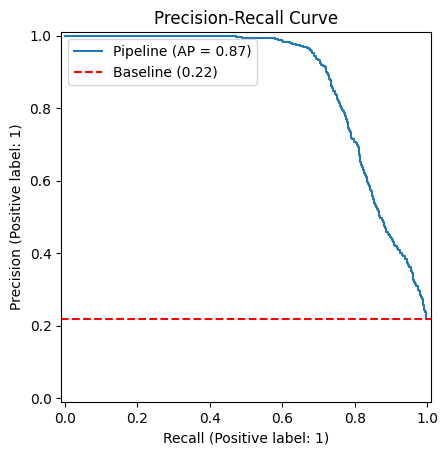

In [94]:
from sklearn.metrics import PrecisionRecallDisplay

disp = PrecisionRecallDisplay.from_estimator(be, X_test, y_test)
disp.ax_.set_title("Precision-Recall Curve")
baseline = y_test.sum() / len(y_test)
plt.axhline(baseline, ls='--', color='r', label=f'Baseline ({round(baseline,2)})')
plt.legend()
plt.show()


###### learning curve

In [95]:
a, b, c = learning_curve(be, X, y, n_jobs=-1, scoring='accuracy')

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


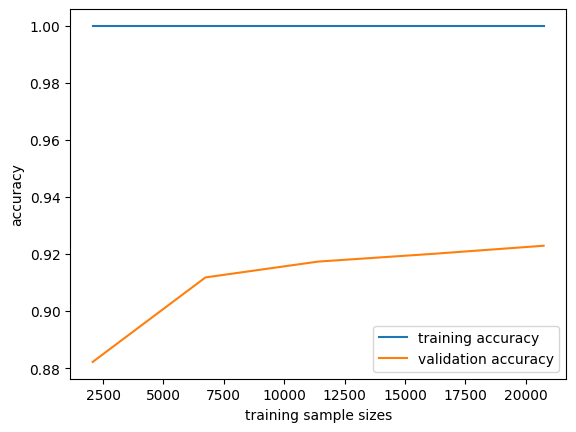

In [96]:
plt.plot(a, b.mean(axis=1), label='training accuracy')
plt.plot(a, c.mean(axis=1),  label='validation accuracy')
plt.xlabel('training sample sizes')
plt.ylabel('accuracy')
plt.legend()

##### Overfitting:

1. High training accuracy (--- low bias)
2. Low testing/ validation accuracy (--- high variance)
3. Big gap between training and validation curves (--- high variance)
4. Overfitting makes a very complex model and learns even the "noise" in the data, which is undesirable

### Part 2

Remedial measures:

1. Add more training samples, if possible, to allow the model to learn better


2. Working with data at hand:

    Make a simpler model / reduce complexity of model:
- try reducing number of features
- try increasing regularization (lambda)
- try pruning the decision trees

In [97]:
grid = {

    RandomForestClassifier(random_state=0, n_jobs=-1, class_weight='balanced'):
    {'model__n_estimators':[100,200,300],
     'model__max_depth':[5, 9, 13],
     'model__min_samples_split':[4,6,8],
     'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]},

#     LGBMClassifier(class_weight='balanced', random_state=0, n_jobs=-1):
#     {'model__n_estimators':[100,200,300],
#      'model__max_depth':[5, 9, 13],
#      'model__num_leaves': [7,15,31],
#      'model__learning_rate':[0.0001,0.001,0.01,0.1,],
#      'model__boosting_type': ['gbdt', 'goss', 'dart'],
#      'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0),
#                                         KNeighborsRegressor()]}
}

In [98]:
for clf, param in grid.items():
    print(clf)
    print('-'*50)
    print(param)
    print('\n')

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0)
--------------------------------------------------
{'model__n_estimators': [100, 200, 300], 'model__max_depth': [5, 9, 13], 'model__min_samples_split': [4, 6, 8], 'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]}




In [99]:
full_df = pd.DataFrame()
best_algos = {}

for clf, param in grid.items():
    pipe = Pipeline([
    ('coltf', ct),
    ('model', clf)
])

    gs = RandomizedSearchCV(estimator=pipe, param_distributions=param, scoring='accuracy',
                            n_jobs=-1, verbose=3, n_iter=4)

    gs.fit(X, y)

    all_res = pd.DataFrame(gs.cv_results_)

    temp = all_res.loc[:, ['params', 'mean_test_score']]
    algo_name = str(clf).split('(')[0]
    temp['algo'] = algo_name

    full_df = pd.concat([full_df, temp])
    best_algos[algo_name] = gs.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [100]:
full_df.sort_values('mean_test_score', ascending=False)

,params,mean_test_score,algo
3,"{'model__n_estimators': 300, 'model__min_sampl...",0.910925,RandomForestClassifier
2,"{'model__n_estimators': 100, 'model__min_sampl...",0.910655,RandomForestClassifier
1,"{'model__n_estimators': 300, 'model__min_sampl...",0.906335,RandomForestClassifier
0,"{'model__n_estimators': 100, 'model__min_sampl...",0.812399,RandomForestClassifier


In [101]:
be = best_algos['RandomForestClassifier']
be

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat_cols',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=13,
                                        min_samples_split=4, n_estimators=300,
                                        n_jobs=-1, random_state=0))])

In [102]:
be.fit(X, y)

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat_cols',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=13,
                                        min_samples_split=4, n_estimators=300,
                                        n_jobs=-1, random_state=0))])

In [103]:
preds = be.predict(X_test)

In [104]:
confusion_matrix(y_test, preds)

array([[4858,  208],
       [ 370, 1048]])

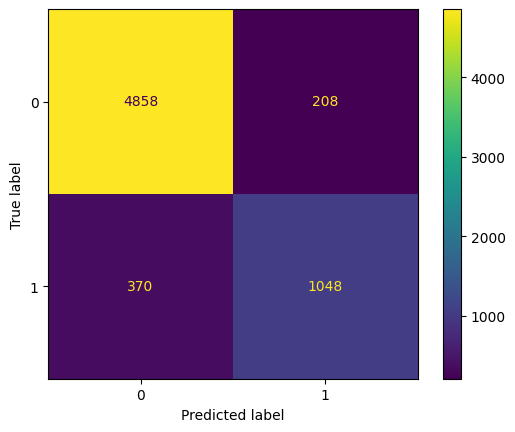

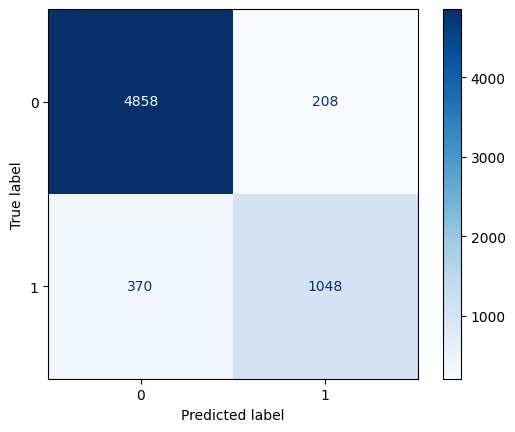

In [106]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(be, X_test, y_test)
disp.plot(cmap="Blues")  # Optional: Set color map
plt.show()


In [107]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      5066
           1       0.83      0.74      0.78      1418

    accuracy                           0.91      6484
   macro avg       0.88      0.85      0.86      6484
weighted avg       0.91      0.91      0.91      6484



In [108]:
be.score(X_test, y_test)

0.9108574953732264

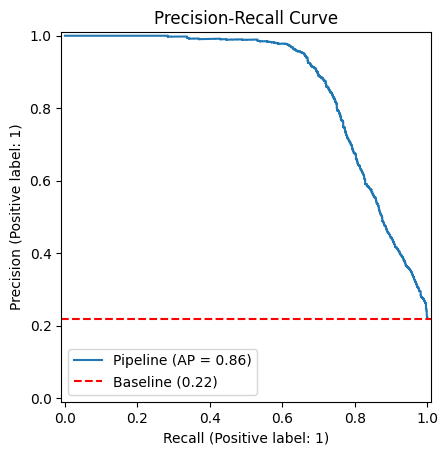

In [110]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

# Plot Precision-Recall Curve
disp = PrecisionRecallDisplay.from_estimator(be, X_test, y_test)
disp.ax_.set_title("Precision-Recall Curve")

# Add baseline
baseline = y_test.sum() / len(y_test)
plt.axhline(baseline, ls='--', color='r', label=f'Baseline ({round(baseline,2)})')
plt.legend()
plt.show()


In [111]:
a, b, c = learning_curve(be, X, y, n_jobs=-1, cv=5)

In [112]:
a

array([ 2073,  6739, 11405, 16071, 20737])

In [113]:
b

array([[0.99131693, 0.9869754 , 0.9869754 , 0.9869754 , 0.9869754 ],
       [0.96958006, 0.96972845, 0.96987684, 0.96987684, 0.96987684],
       [0.96045594, 0.96212188, 0.95922841, 0.95984217, 0.95984217],
       [0.9556966 , 0.95538548, 0.95432767, 0.95532325, 0.95606994],
       [0.95129479, 0.95023388, 0.95115012, 0.95264503, 0.95076433]])

In [114]:
c

array([[0.88023144, 0.88601736, 0.88850309, 0.88638117, 0.88522377],
       [0.90395371, 0.90433944, 0.90856481, 0.90393519, 0.90412809],
       [0.9072324 , 0.90742527, 0.91222994, 0.9068287 , 0.91068673],
       [0.90761813, 0.90858245, 0.91608796, 0.90875772, 0.90914352],
       [0.90896818, 0.91051109, 0.91531636, 0.91030093, 0.91068673]])

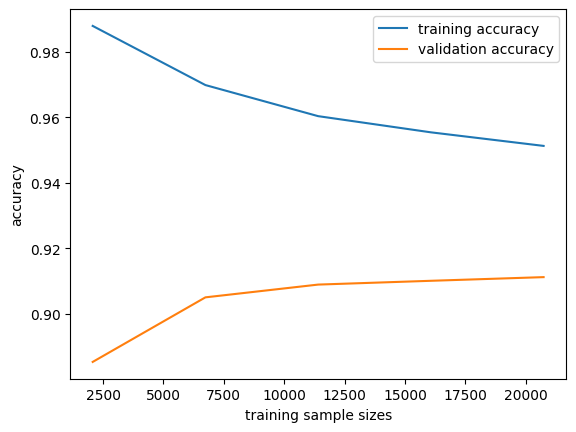

In [115]:
plt.plot(a, b.mean(axis=1), label='training accuracy')
plt.plot(a, c.mean(axis=1),  label='validation accuracy')
plt.xlabel('training sample sizes')
plt.ylabel('accuracy')
plt.legend()

In [117]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(be, f)  # Save the model
